In [60]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import gillespie as gp
import statistics as st


Gillespie SIR (Stochastic model)

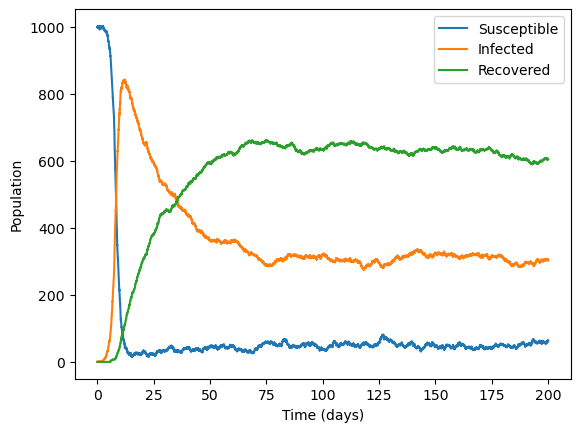

In [61]:
def gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # initialize arrays to store the variables
    X = [X0]
    Y = [Y0]
    Z = [Z0]
    t = [0]

    # Gillespie algorithm loop
    while t[-1] < tend:
        current_X = X[-1]
        current_Y = Y[-1]
        current_Z = Z[-1]
        
        # If no susceptible and infected, break out of the loop (epidemic is over)
        if current_Y == 0 and current_X == 0:
            break

        # Calculate rates for all events
        birth_rate = mu * N
        infection_rate = beta * current_X * current_Y / N
        recovery_rate = gamma * current_Y
        death_susc_rate = mu * current_X
        death_inf_rate = mu * current_Y
        death_recov_rate = mu * current_Z

        rates = [birth_rate, infection_rate, recovery_rate,
                 death_susc_rate, death_inf_rate, death_recov_rate]
        rate_sum = sum(rates)

        # if rate_sum is zero, no more events possible
        if rate_sum <= 0:
            break  # No more events can happen, end the simulation

        # Time until next event (exponentially distributed)
        tau = np.random.exponential(scale=1/rate_sum)
        t.append(t[-1] + tau)  # Append the new time

        rand = random.uniform(0, rate_sum)
        cum_rate = 0

        # determine which event happens
        if rand < (cum_rate := cum_rate + birth_rate): # birth event
            current_X += 1
        
        elif rand < (cum_rate := cum_rate + infection_rate) and current_X > 0: # infection event
            current_X -= 1
            current_Y += 1
        
        elif rand < (cum_rate := cum_rate + recovery_rate) and current_Y > 0: # recovery event
            current_Y -= 1
            current_Z += 1

        elif rand < (cum_rate := cum_rate + death_susc_rate):  # death of susceptible
            current_X -= 1

        elif rand < (cum_rate := cum_rate + death_inf_rate):  # death of infected
            current_Y -= 1

        elif rand < (cum_rate := cum_rate + death_recov_rate): # death of recovered
                current_Z -= 1

        X.append(current_X)
        Y.append(current_Y)
        Z.append(current_Z)
    return X, Y, Z, t


N = 1000
tend = 200 # simulation time (200 days)
beta = 1
gamma = 1/30
mu = 1/60
X0 = 999
Y0 = 1
Z0 = 0
seed = 42

Xs, Ys, Zs, t = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

# Plot the results
plt.plot(t, Xs, label="Susceptible")
plt.plot(t, Ys, label="Infected")
plt.plot(t, Zs, label="Recovered")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.show()

Deterministic SIR model

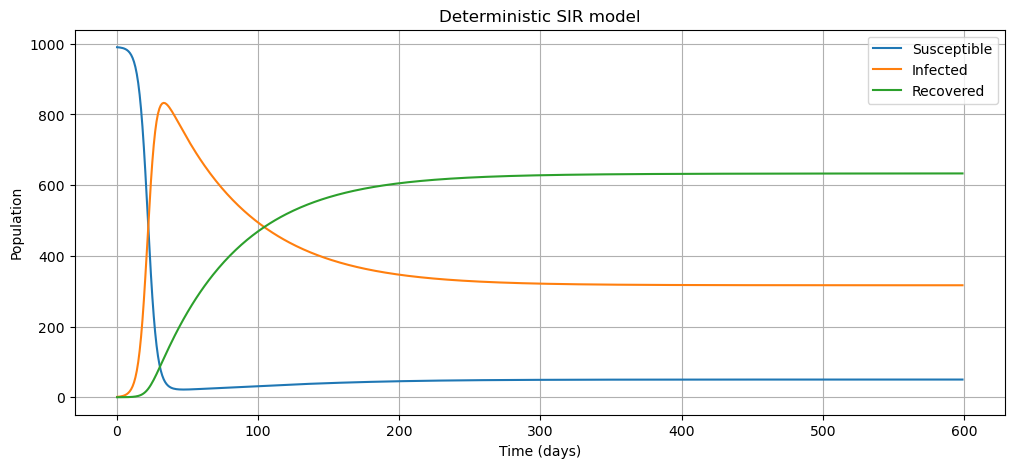

In [62]:
beta = 1
gamma = 1/30
mu = 1/60
N = 1000
X0 = 990
Y0 = 1
Z0 = 0
start_t = 0
end_t = 200
points_t = 600
init_val = [X0, Y0, Z0]

def SIR(val, t, beta, gamma, mu):
    X, Y, Z = val

    dXdt = mu * N - beta * X * Y / N - mu * X 
    dYdt = beta * X * Y / N - gamma * Y - mu * Y 
    dZdt = gamma * Y - mu * Z 
    
    return np.array([dXdt, dYdt, dZdt])


def deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t):

    time = np.linspace(start_t, end_t, points_t)
    solution = odeint(SIR, init_val, time, args=(beta, gamma, mu))
    Xd, Yd, Zd = solution.T

    return Xd, Yd, Zd, time


Xd, Yd, Zd, time = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

plt.figure(figsize=(12,5))
plt.plot(Xd, label="Susceptible")
plt.plot(Yd, label="Infected")
plt.plot(Zd, label = "Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("Deterministic SIR model")
plt.legend()
plt.grid()

# plt.savefig('FittingSIR.png', dpi=300)
plt.show()


Gillespie SIR (with package)

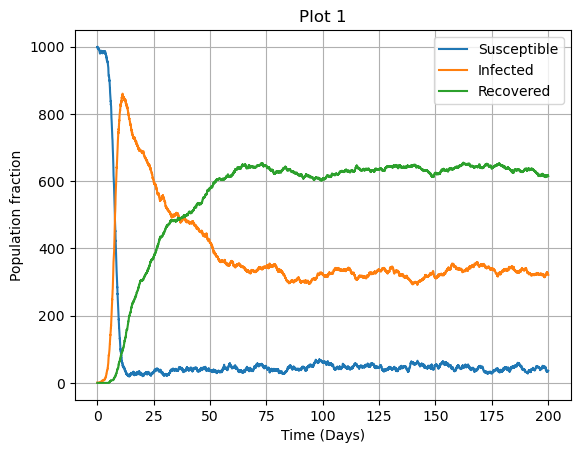

In [63]:
beta = 1
gamma = 1/30
mu = 1/60
N = 1000
X0 = 999
Y0 = 1
Z0 = 0
init_val = [X0, Y0, Z0]

def gillespie_SIR(X, Y, Z, N, beta, gamma, mu):
    propensities = [lambda X, Y, Z: mu * N,
                lambda X, Y, Z: beta * X * Y / N,
                lambda X, Y, Z: gamma * Y,
                lambda X, Y, Z: mu * X,
                lambda X, Y, Z: mu * Y,
                lambda X, Y, Z: mu * Z]

    stoichiometry = [[1, 0, 0],
                 [-1, 1, 0],
                 [0, -1, 1],
                 [-1, 0, 0],
                 [0, -1, 0],
                 [0, 0, -1]]

    times, XYZ = gp.simulate(init_val, propensities, stoichiometry, duration = 200) 

    Xs, Ys, Zs = zip(*XYZ)

    return Xs, Ys, Zs, times

Xs, Ys, Zs, times = gillespie_SIR(X0, Y0, Z0, N, beta, gamma, mu)


plt.plot(times, Xs, label = "Susceptible")
plt.plot(times, Ys, label = "Infected")
plt.plot(times, Zs, label = "Recovered")

plt.title("Plot 1")
plt.xlabel("Time (Days)")
plt.ylabel("Population fraction")
plt.legend()
plt.grid()

plt.show()

Plotting deterministic and stochastic SIR

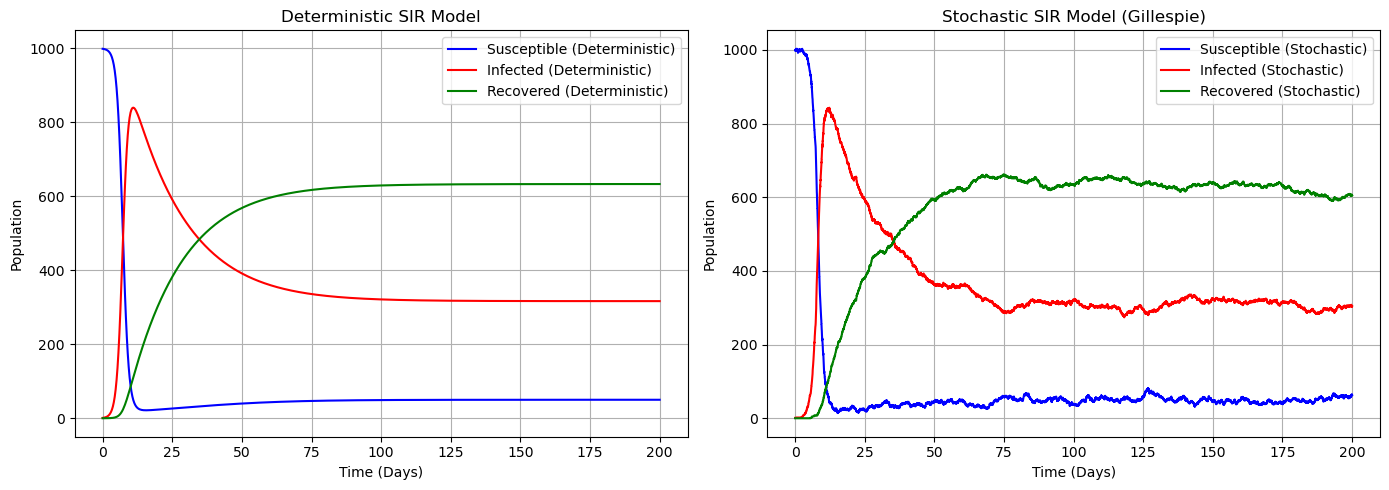

In [64]:
# solve the deterministic model
Xd, Yd, Zd, time = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)
# solve the stochastic model using the Gillespie algorithm
Xs, Ys, Zs, t = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot the deterministic model on the first subplot (ax1)
ax1.plot(time, Xd, label="Susceptible (Deterministic)", color='blue')
ax1.plot(time, Yd, label="Infected (Deterministic)", color='red')
ax1.plot(time, Zd, label="Recovered (Deterministic)", color='green')
ax1.set_title("Deterministic SIR Model")
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Population")
ax1.legend(loc="best")
ax1.grid(True)

# Plot the stochastic model on the second subplot (ax2)
ax2.plot(t, Xs, label="Susceptible (Stochastic)", color='blue')
ax2.plot(t, Ys, label="Infected (Stochastic)", color='red')
ax2.plot(t, Zs, label="Recovered (Stochastic)", color='green')
ax2.set_title("Stochastic SIR Model (Gillespie)")
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Population")
ax2.legend(loc="best")
ax2.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Function to run multiple simulations of Gillespie's agorithm and return mean and variance of X, Y, Z across simulations

- beta different values on x-axis and var on y-axis for both X and Y
- gamma "
- mu "

Number of simulations: 50
Final mean of Susceptibles: 70.10679881332464
Final variance of Susceptibles: 18584.491833670832
Final mean of Infected: 308.47964237304905
Final variance of Infected: 2356.2539246068145


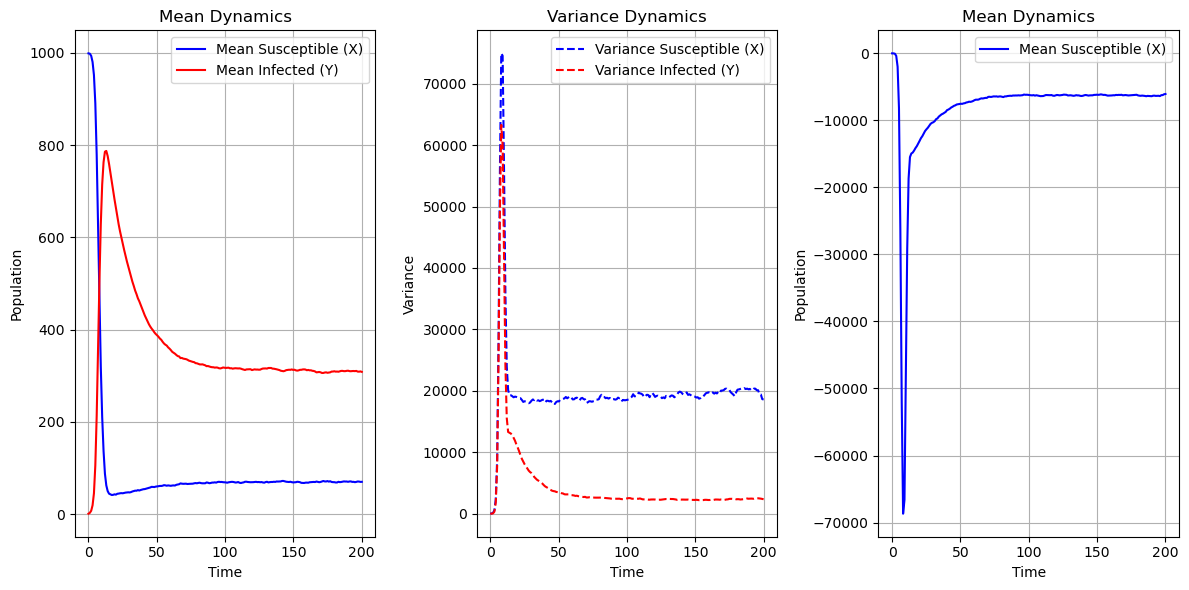

In [81]:
# Assuming gillespie_sir is defined elsewhere
def run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed):
    # will accumulate Xs, Ys, Zs across simulations
    all_Xs = [] 
    all_Ys = []  
    all_Zs = []
    cov_array = np.zeros(tend)

    time_p = np.linspace(0, tend, 200) # 200 time points

    for i in range(sims):
        # Run the Gillespie simulation for the current iteration
        Xs, Ys, Zs, t = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend)

        # interpolate to have consistent time points
        X_interp = np.interp(time_p, t, Xs)
        Y_interp = np.interp(time_p, t, Ys)
        Z_interp = np.interp(time_p, t, Zs)

        all_Xs.append(X_interp)
        all_Ys.append(Y_interp)
        all_Zs.append(Z_interp)

    all_Xs = np.array(all_Xs)
    all_Ys = np.array(all_Ys)
    all_Zs = np.array(all_Zs)

    # average population size of each compartment at each time point
    mean_Xs = np.mean(all_Xs, axis = 0)
    mean_Ys = np.mean(all_Ys, axis = 0)
    mean_Zs = np.mean(all_Zs, axis = 0)

    # variability of population sizes from the mean across different simulations
    var_Xs = np.var(all_Xs, axis = 0)
    var_Ys = np.var(all_Ys, axis = 0)
    var_Zs = np.var(all_Zs, axis = 0)

    return time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys

def covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend):

    cov_Xs_Ys = np.zeros(tend)

    for t in range(tend):
        cov_Xs_Ys[t] = np.mean((all_Xs[:, t] - mean_Xs[t]) * (all_Ys[:, t] - mean_Ys[t]))
    
    return cov_Xs_Ys

def mean_det_inf(sims, X0, Y0, Z0, Yd, beta, gamma, mu, N, tend):

    all_Yd = []

    for i in range(sims):

        Xd, Yd, Zd, time = deterSol(X0, Y0, Z0, N, beta, gamma, mu, 0, tend, 200)

        all_Yd.append(Yd)

    mean_Yd = np.mean(all_Yd, axis=0)  
    
    return mean_Yd
 

# Parameters (Assuming they are defined elsewhere)
sims = 50
X0 = 999
Y0 = 1
Z0 = 0
beta = 1
gamma = 1/30
mu = 1/60
N = X0 + Y0 + Z0
tend = 200

# Run the stochastic simulations
time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)
cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend)

# Print the results
print(f"Number of simulations: {sims}")
print(f"Final mean of Susceptibles: {mean_Xs[-1]}")
print(f"Final variance of Susceptibles: {var_Xs[-1]}")
print(f"Final mean of Infected: {mean_Ys[-1]}")
print(f"Final variance of Infected: {var_Ys[-1]}")


# plotting the mean and the variance
fig, axes = plt.subplots(1, 3, figsize = (12,6))

# Plot Mean on the first subplot (axes[0])
axes[0].plot(time_p, mean_Xs, label='Mean Susceptible (X)', color='blue')
axes[0].plot(time_p, mean_Ys, label='Mean Infected (Y)', color='red')
axes[0].set_title("Mean Dynamics")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Population")
axes[0].legend()
axes[0].grid(True)

# Plot Variance on the second subplot (axes[1])
axes[1].plot(time_p, var_Xs, label='Variance Susceptible (X)', color='blue', linestyle='--')
axes[1].plot(time_p, var_Ys, label='Variance Infected (Y)', color='red', linestyle='--')
axes[1].set_title("Variance Dynamics")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Variance")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(time_p, cov_Xs_Ys, label='Mean Susceptible (X)', color='blue')
# axes[2].plot(time_p, mean_Ys, label='Mean Infected (Y)', color='red')
axes[2].set_title("Mean Dynamics")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Population")
axes[2].legend()
axes[2].grid(True)

# Adjust spacing between the two plots
plt.tight_layout()


<class 'numpy.ndarray'>


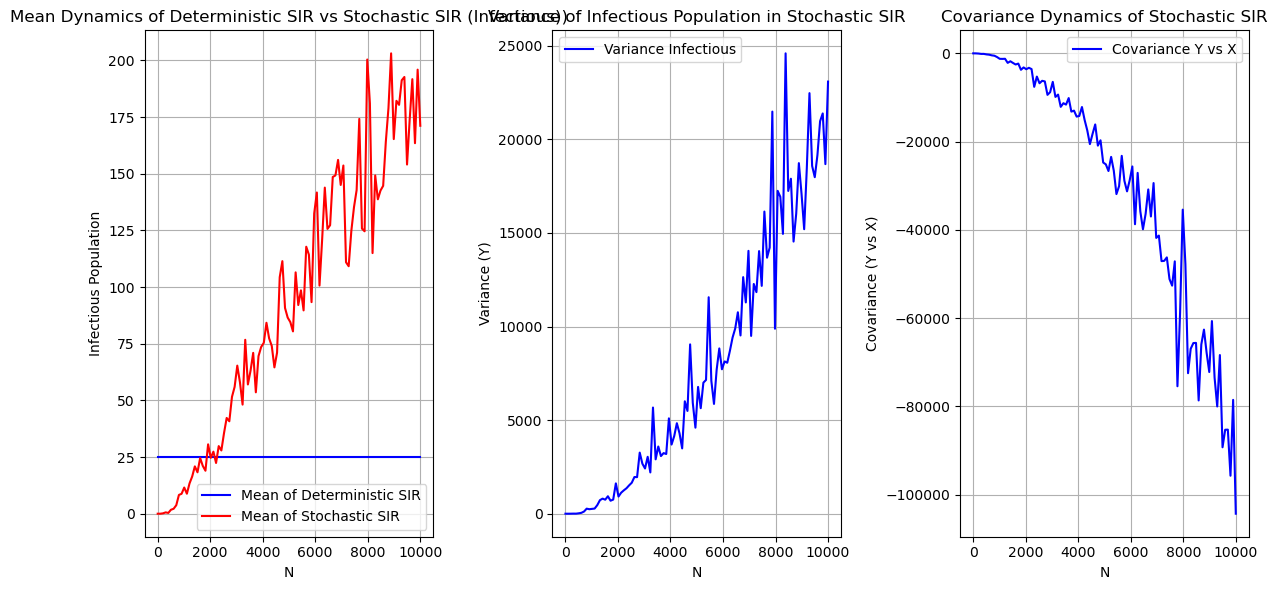

[25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137, 25.170603044220137,

In [95]:
N_diff = np.linspace(2, 10000, 100)
Y0_diff = np.linspace(2, 1000, 50)
beta_diff = np.linspace(0, 10, 20)
gamma_diff = np.linspace(0, 10, 20)
mu_diff = np.linspace(0, 3, 20)


beta = 1
gamma = 1/3
mu = 1/60
sims = 50

fig, axes = plt.subplots(1, 3, figsize = (12,6))

def diff_params(N_diff, Y0, beta, gamma, mu):
    
    mean_deter = []
    mean_stoch = []
    var_Y = []
    cov_XY = []

    for n in np.nditer(N_diff):

        X0 = n - 1
        Y0 = 1
        Z0 = 0  

        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, n, tend = 100)
        mean_Yd = mean_det_inf(sims, X0, Y0, Z0, Yd, beta, gamma, mu, n, tend = 100)
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend = 100)

        mean_deter.append(mean_Yd[-1])
        mean_stoch.append(mean_Ys[-1])
        var_Y.append(var_Ys[-1])
        cov_XY.append(cov_Xs_Ys[-1])

    axes[0].plot(N_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')
    axes[0].plot(N_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')
    axes[0].set_title("Mean Dynamics of Deterministic SIR vs Stochastic SIR (Infectious))")
    axes[0].set_xlabel("N")
    axes[0].set_ylabel("Infectious Population")
    axes[0].legend()
    axes[0].grid(True)

    # Plot Variance on the second subplot (axes[1])
    axes[1].plot(N_diff, var_Y, label='Variance Infectious', color='blue')
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("N")
    axes[1].set_ylabel("Variance (Y)")
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(N_diff, cov_XY, label='Covariance Y vs X', color='blue')
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("N")
    axes[2].set_ylabel("Covariance (Y vs X)")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    return mean_deter


print(type(N_diff))
mean_deter = diff_params(N_diff, Y0, beta, gamma, mu)
print(mean_deter)
        
            


    